In [297]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from sklearn import preprocessing
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings("ignore")

### 0. Data Prep

In [298]:
# Load training data (labelled)
train = pd.read_csv('songs_train.csv')
train = train.set_index('song_id')
train.head()

,genre,audio_danceability,audio_energy,audio_key,audio_loudness,audio_mode,audio_speechiness,audio_acousticness,audio_instrumentalness,audio_liveness,...,lyrics_year,lyrics_years,lyrics_yellow,lyrics_yes,lyrics_yesterday,lyrics_yet,lyrics_yo,lyrics_york,lyrics_young,lyrics_zone
song_id,,,,,,,,,,,,,,,,,,,,,
1,pop,0.733,0.886,2,-1.856,0,0.0426,0.0481,0.000002,0.1910,...,0,0,0,0,0,0,0,0,0,0
2,pop,0.685,0.886,0,-4.179,1,0.0340,0.0280,0.000000,0.4810,...,0,0,0,0,0,0,0,0,0,0
3,pop,0.691,0.695,0,-5.600,1,0.0367,0.0592,0.000000,0.0647,...,0,0,0,0,0,0,0,0,0,0
4,pop,0.761,0.739,6,-3.591,1,0.0369,0.1780,0.000003,0.2300,...,0,0,0,0,0,0,0,0,0,0
5,pop,0.744,0.828,2,-5.911,1,0.0289,0.0646,0.000014,0.0858,...,0,0,0,0,0,0,0,0,0,0


In [299]:
# Split for EDA
audio = train.loc[:, train.columns.str.startswith('audio')]
audio['genre'] = train.loc[:,'genre']
lyrics = train.loc[:, train.columns.str.startswith('lyrics')]
lyrics['genre'] = train.loc[:,'genre']

In [300]:
# Normalise audio data
x = audio.select_dtypes('number').values
min_max_scaler = preprocessing.MinMaxScaler()
audio_scaled = pd.DataFrame(min_max_scaler.fit_transform(x))
audio_scaled.columns = audio.select_dtypes('number').columns
audio_scaled = audio_scaled.set_index(train.index)
audio_scaled['genre'] = train.loc[:,'genre']

---
### 1. Descriptive Statistics

We will analyse the characteristics of the 10000 song sample. There are 12 audio columns and 1221 lyric columns.

#### 1.1 Values per Class
Can see that the classes are well-balanced but there are a lot of identical songs which exist across genres.

In [5]:
# Values per Class
gen = pd.DataFrame(train.groupby('genre')['genre'].count()).rename(columns={'genre':'#'})
gen['%'] = 100 * gen  / gen.sum()
gen

,#,%
genre,,
hip hop,2289,22.89
pop,2565,25.65
rap,2450,24.50
rock,2696,26.96


In [295]:
temp = train.duplicated(keep = False,subset = list(train.columns.values)[1:])
dupes = train[temp].iloc[:,1:].groupby(list(train.columns.values)[1:]).max().reset_index()
train[temp] # 2054 songs duplicated
dupes = dupes.reset_index().rename(columns={'index':'group'})
dupes2 = pd.merge(dupes,
                  train.reset_index(),
                  how ='left',
                  on = list(train.columns.values)[1:])[['group','song_id','genre']]
dupes3 = pd.DataFrame(dupes2.set_index('song_id').groupby('group')['genre'].transform(lambda x: ','.join(x)))
fine = ['hip hop,hip hop,hip hop','rap,rap,rap,rap','rap,rap,rap', 'rock,rock,rock,rock','rock,rock,rock','pop,pop', 'hip hop,hip hop', 'rock,rock', 'rap,rap', 'pop,pop,pop','pop,pop,pop,pop']
dupes4 = dupes3[ ~dupes3['genre'].isin(fine)]
# dupes4.to_csv('dupesongs.csv')
dupes5 = dupes4.reset_index().groupby('genre').count().sort_values(by = 'song_id',ascending = False)#.reset_index().reset_index().groupby('genre').count()
dupes5['genretr'] = ['-'.join(list(set(l.split(',')))) for l in list(dupes5.reset_index()['genre'])]
dupes5.groupby('genretr').sum().sort_values(by='song_id', ascending=False)

,song_id
genretr,
rap-hip hop,646
rap-pop,220
rock-pop,57
hip hop-pop,40
rock-hip hop,31
rap-hip hop-pop,16
rock-rap,9
rock-rap-pop,6


#### 1.2 Audio features

- Variability: From the below it looks like all audio features apart from loudness, key, tempo and duration_ms are on a [0,1] scale. May consider normalising features as part of data prep process. Also can see that key and mode seem to have higher variances relative to other audio features.
- Centrality: Except for instrumentalness and mode, median and mean values appear to be close in most of this data, which suggests that the data are largely symmetrically distributed.
- Distribution: Audio mode appears to be a binary/categorical variable (only 0,1 values). Instrumentalness incredibly right skewed. Can see audio key has relatively large distribution of values (would expect this) - this could make it a good way of differentiating genre. Interestingly small variation in duration (on average 3 mins 51 seconds) - perhaps not a good differentiator.

In [6]:
# Centrality - min, median, mean, max
audio.describe().loc[['min','50%','mean','max']].T.sort_values('max')

,min,50%,mean,max
audio_loudness,-24.149000,-6.160000,-6.676959,0.221
audio_speechiness,0.022300,0.079200,0.140995,0.943
audio_danceability,0.112000,0.660000,0.647790,0.981
audio_instrumentalness,0.000000,0.000001,0.031413,0.981
audio_valence,0.030500,0.547000,0.539495,0.985
audio_liveness,0.016700,0.135000,0.196531,0.986
audio_acousticness,0.000003,0.068700,0.156232,0.991
audio_energy,0.003570,0.714000,0.699362,0.999
audio_mode,0.000000,1.000000,0.603700,1.000
audio_key,0.000000,6.000000,5.322100,11.000


In [359]:
# Centrality - Normalised Variance
audio_scaled.select_dtypes('number').drop('audio_key', axis=1).drop('audio_mode', axis=1).var(axis=0).sort_values()

audio_duration_ms         0.002705
audio_loudness            0.013458
audio_instrumentalness    0.016549
audio_speechiness         0.019081
audio_liveness            0.024587
audio_energy              0.028837
audio_danceability        0.033149
audio_tempo               0.035869
audio_acousticness        0.041389
audio_valence             0.054598
dtype: float64

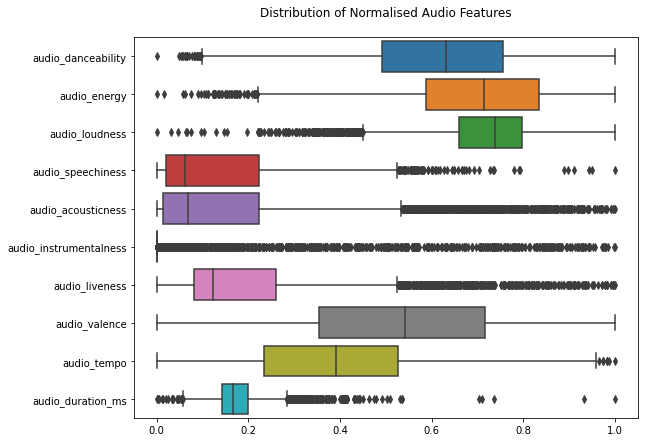

In [329]:
# Distribution
boxdat = pd.DataFrame(audio_scaled.select_dtypes('number').drop('audio_key', axis=1).drop('audio_mode', axis=1).stack().reset_index())
fig = plt.figure(figsize = (10,7))
sns.boxplot(data=boxdat, x=0, y="level_1")
plt.title("Distribution of Normalised Audio Features\n")
plt.xlabel('')
plt.ylabel('')
plt.gcf().subplots_adjust(left=0.2)
fig.savefig('../writeup/Figures/DistOfNormAudioFeatures.jpg');

In [351]:
cnts_key = audio['audio_key'].astype('category')
cnts_mode = audio['audio_mode'].astype('category')

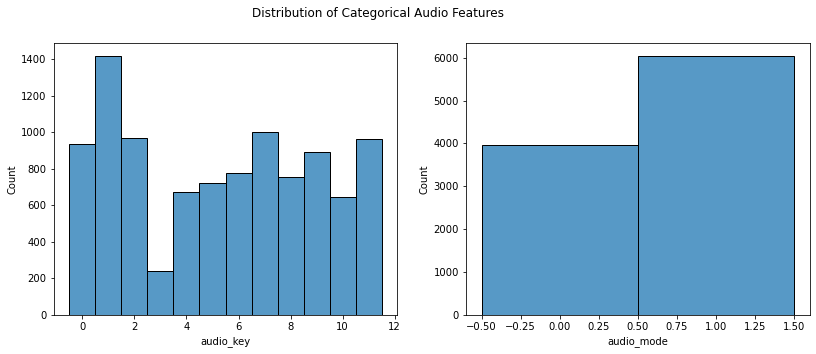

In [357]:
# Distribution by class - Numerics
fig, axis = plt.subplots(1,2, figsize=(15, 5))
plt.suptitle('Distribution of Categorical Audio Features')
sns.histplot(data = cnts_key, ax = axis[0])
sns.histplot(data = cnts_mode, ax = axis[1])
plt.gcf().subplots_adjust(left=0.2)
fig.savefig('../writeup/Figures/DistofCatAudioFeats.jpg');

#### 1.3 Lyric features
- Can see most words have fewer than 500 mentions across the data
- High dimensionality (1221 lyric columns) but 80% of mentions made up by 49% of words
- A lot of the features with highest mentions overall (>3500 mentions) are not 'words' but rather singing sounds such as "ooh", "ya", "la" etc. Unsurprising as these get repeated a lot in songs.

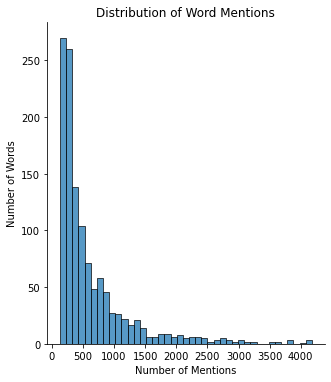

In [302]:
# Distribution of word counts
word_cnts = lyrics.select_dtypes('number').sum(axis=0).sort_values(ascending=False)
fig = sns.displot(word_cnts)
plt.title('Distribution of Word Mentions')
plt.xlabel('Number of Mentions')
plt.ylabel('Number of Words')
plt.gcf().subplots_adjust(left=0.2)
fig.savefig('../writeup/Figures/DistOfWordMentions.jpg');

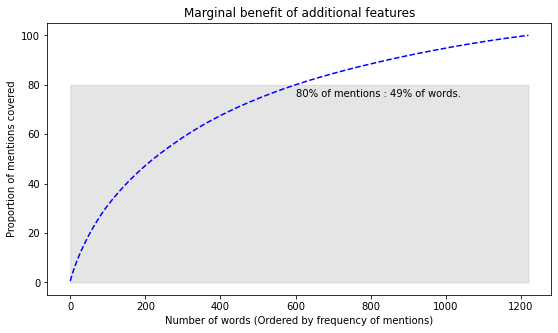

In [10]:
# Marginal benefit in additional words
y = word_cnts.cumsum()*100/word_cnts.sum()
x = word_cnts.reset_index().index
pc80no = list(y).index(list(y[y>80])[0])
pc80 = round(100*pc80no/max(x))
fig, ax = plt.subplots(figsize=(10, 5))
ax.annotate(f"80% of mentions : {pc80}% of words.",(pc80no,75))
ax.fill_between(x,0,80, color = 'grey', alpha=0.2)
ax.plot(x, y, linestyle='--', color='b', label = 'nouns')
plt.xlabel('Number of words (Ordered by frequency of mentions)')
plt.ylabel('Proportion of mentions covered')
ax.set_title('Marginal benefit of additional features')
plt.gcf().subplots_adjust(left=0.2)
fig.savefig('../writeup/Figures/MarginalBenefitLyrics.jpg');

In [325]:
#gencnts = pd.DataFrame(lyrics.groupby('genre').sum().stack()).sort_values(by=0, ascending = False).reset_index()
gencnts[gencnts['level_1']=='lyrics_uh']
gencnts[gencnts['level_1']=='lyrics_girl']

,genre,level_1,0
15,rap,lyrics_girl,1353
36,hip hop,lyrics_girl,1101
39,pop,lyrics_girl,1062
129,rock,lyrics_girl,663


In [11]:
# Top words overall
wordf = pd.DataFrame(word_cnts)
wordf['word'] = [w.removeprefix('lyrics_') for w in list(word_cnts.index)]
wordf = wordf.reset_index().iloc[:,1:3].rename(columns={0:'cnt'})
wordf[wordf['cnt'] > 3500]

,cnt,word
0,4179,girl
1,4128,hey
2,4081,yo
3,4019,ya
4,3836,la
5,3796,gonna
6,3795,money
7,3680,uh
8,3647,away
9,3532,good


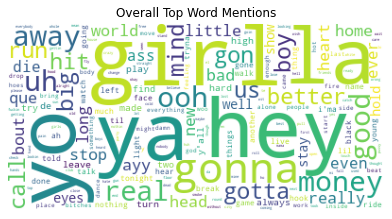

In [12]:
# Wordcloud
data = wordf.set_index('word').to_dict()['cnt']
fig, ax = plt.subplots(figsize=(7.5, 5))
ax.set_title('Overall Top Word Mentions')
ax.set_axis_off()
topwords = WordCloud(background_color = 'white').generate_from_frequencies(data)
ax.imshow(topwords)
plt.gcf().subplots_adjust(left=0.2)
fig.savefig('../writeup/Figures/OverallWordCloud.jpg');

### 2.1 EDA for Audio Features

- Can see energy is positively correlated with loudness (0.65), and negatively correlated with acousticness, we may want to consider dropping this feature to avoid adding variability to the model. Other than this there is minimal correlation between the features.
- Interestingly all the audio features vary with genre according to anova test at 5% confidence level, although the features which had most significant difference were danceability and speechiness
- When looking at those two features can see that rap and hip-hop significantly higher in "speechliness", and rock significantly lower in "danceability" as you may expect

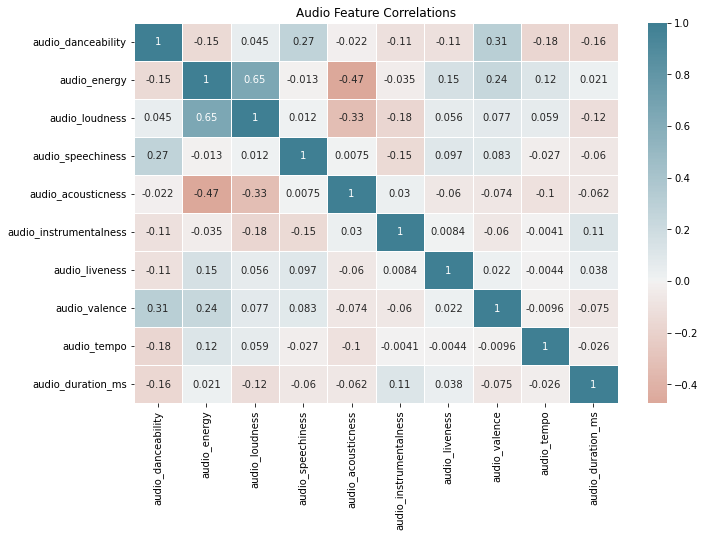

In [358]:
# Correlation Analysis
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title('Audio Feature Correlations')
correlations = audio_scaled.select_dtypes('number').drop('audio_key', axis=1).drop('audio_mode', axis=1).corr()
sns.heatmap(correlations, annot=True, linewidth=.5, center=0, cmap=sns.diverging_palette(20, 220, as_cmap=True))
plt.gcf().subplots_adjust(left=0.2)
fig.savefig('../writeup/Figures/NumFeatureCorr.jpg');

In [14]:
# Anova - which features vary most with genre
featdic = {}
for i in range(12):
    gs = []
    for g in audio_scaled['genre'].unique():
        gs.append(list(audio_scaled[audio_scaled['genre']==g].iloc[:,i]))
    featdic[audio_scaled.iloc[:,i].name] = f_oneway(gs[0],gs[1],gs[2],gs[3])[1]
    
anova = pd.DataFrame.from_dict(featdic, orient = 'index').rename(columns={0:'p-value'})
anova[anova['p-value'] < 0.05].sort_values('p-value')

,p-value
audio_danceability,0.000000e+00
audio_speechiness,0.000000e+00
audio_duration_ms,1.061190e-124
audio_loudness,9.674073e-111
audio_instrumentalness,7.763057e-52
audio_tempo,1.573903e-40
audio_liveness,2.499670e-21
audio_energy,6.818506e-19
audio_mode,2.469769e-18
audio_valence,4.103568e-13


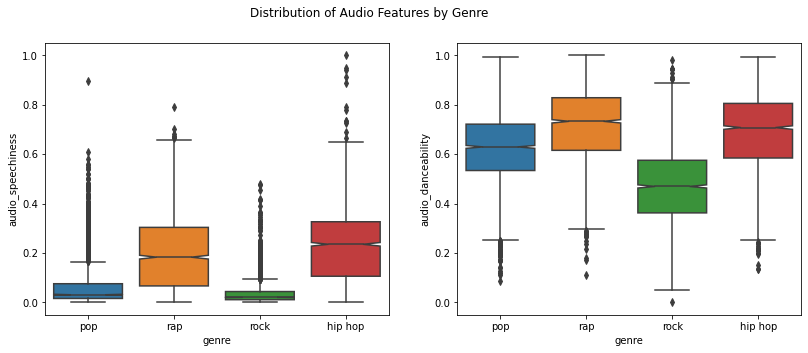

In [27]:
# Distribution by class - Numerics
fig, ax = plt.subplots(1,2, figsize=(15, 5))
plt.suptitle('Distribution of Audio Features by Genre')
sns.boxplot(data=audio_scaled.loc[:,['audio_speechiness', 'genre']],notch=True, ax = ax[0], x="genre", y="audio_speechiness", hue="genre", dodge=False)
sns.boxplot(data=audio_scaled.loc[:,['audio_danceability', 'genre']],notch=True,ax=ax[1], x="genre", y="audio_danceability", hue="genre", dodge=False)
for a in ax:
    a.legend([],[], frameon=False)
plt.gcf().subplots_adjust(left=0.2)
fig.savefig('../writeup/Figures/AudioFeatsByGenre.jpg');

#### ANOVA Revisited

After some model building can see that they are not so good at differentiating hip hop and pop. Looking to see which features are the best at distinguishing them.

In [23]:
audio_scaled_rhh = audio_scaled[(audio_scaled['genre'] == 'hip hop') | (audio_scaled['genre'] == 'rap')]

In [25]:
# Anova - which features vary most with genre
featdic_rhh = {}
for i in range(12):
    gs = []
    for g in audio_scaled_rhh['genre'].unique():
        gs.append(list(audio_scaled_rhh[audio_scaled_rhh['genre']==g].iloc[:,i]))
    featdic_rhh[audio_scaled_rhh.iloc[:,i].name] = f_oneway(gs[0],gs[1])[1]
    
anova_rhh = pd.DataFrame.from_dict(featdic_rhh, orient = 'index').rename(columns={0:'p-value'})
anova_rhh[anova_rhh['p-value'] < 0.05].sort_values('p-value')

,p-value
audio_tempo,8.683802e-23
audio_speechiness,3.278699e-15
audio_valence,5.627406e-15
audio_loudness,5.629533e-14
audio_duration_ms,5.576907e-10
audio_liveness,1.000167e-09
audio_danceability,2.205306e-09
audio_energy,6.318466e-05
audio_key,4.064997e-03


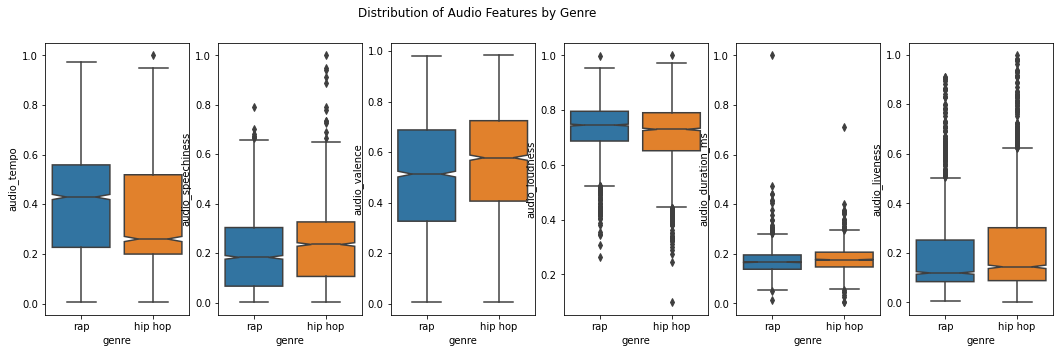

In [31]:
# Distribution by class - Numerics
fig, ax = plt.subplots(1,6, figsize=(20, 5))
plt.suptitle('Distribution of Audio Features by Genre')

aufeats = ['audio_tempo', 'audio_speechiness','audio_valence', 'audio_loudness','audio_duration_ms','audio_liveness']

for a in aufeats:
    sns.boxplot(data=audio_scaled_rhh.loc[:,[a, 'genre']],notch=True, ax = ax[aufeats.index(a)], x="genre", y=a, hue="genre", dodge=False)
#sns.boxplot(data=audio_scaled_rhh.loc[:,['audio_tempo', 'genre']],notch=True,ax=ax[1], x="genre", y="audio_tempo", hue="genre", dodge=False)
for a in ax:
    a.legend([],[], frameon=False)
plt.gcf().subplots_adjust(left=0.2)
fig.savefig('../writeup/Figures/AudioFeatsByGenre_rapvshiphop.jpg');

### 2.2 EDA for Lyric Features
- Stumbled upon this realisation: by looking for correlated words we get many words in other languages, perhaps we could convert these to English and add to existing features (although hard to know which language to translate from), or drop the features from the data, or make a flag to indicate that this song is in a different language. Choice will affect how model performs on other languages.
- An exception to this is 'lean' and 'shoulder'. Makes sense :)
- Looking at top word counts per genre, can see some overlap between hip hop and rap (money in top 5 most mentioned words in both) and pop and rock (hey, away, gonna and ooh in top 5 for both). This suggests that these features may make it difficult to distinguish pop and rock from each other, but simpler to distinguish from hip hop and rap.

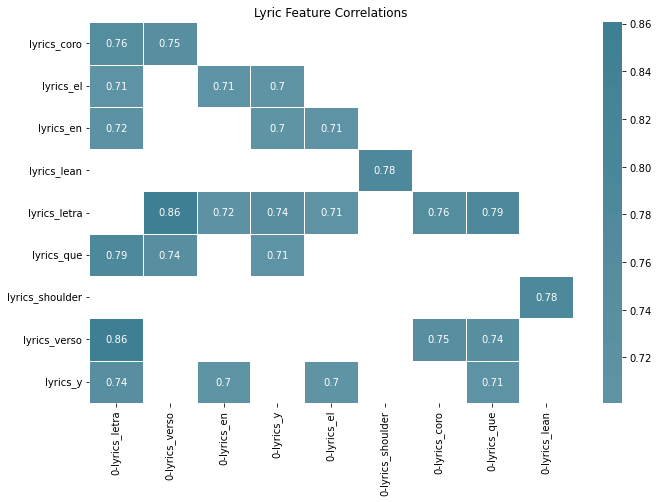

In [16]:
# Feature Correlation by Genre
lyrcor = pd.DataFrame(lyrics.select_dtypes('number').corr().stack())
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title('Lyric Feature Correlations')
correlations = lyrcor[(abs(lyrcor[0])>0.7) & (abs(lyrcor[0])!=1)].unstack()
co = sns.heatmap(correlations, annot=True, linewidth=.5, center=0, cmap=sns.diverging_palette(20, 220, as_cmap=True))
co.set(xlabel=None)
plt.gcf().subplots_adjust(left=0.2)
fig.savefig('../writeup/Figures/LyricFeatureCorr.jpg');

In [17]:
# Top n words by genre
lyrcnt = pd.DataFrame(lyrics.groupby('genre').sum().stack()).reset_index()
lyrcnt['level_1'] = [l.removeprefix('lyrics_') for l in list(lyrcnt['level_1'])]
lyrcnt = lyrcnt.merge(lyrcnt.groupby('genre').sum(), on='genre').sort_values(['genre', '0_x'], ascending = False)
lyrcnt['%'] = lyrcnt.loc[:,'0_x']/lyrcnt.loc[:,'0_y']
lyrcnt = lyrcnt.groupby('genre').head(5)[['genre','level_1']]
lyrcnt.groupby('genre')['level_1'].apply(','.join)

genre
hip hop         yo,ya,uh,money,real
pop        gonna,ooh,hey,heart,away
rap              que,la,yo,money,de
rock        away,gonna,well,hey,ooh
Name: level_1, dtype: object

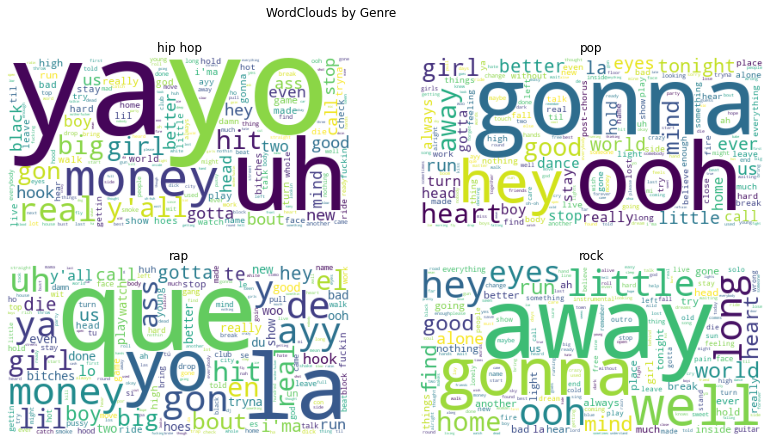

In [18]:
# Wordclouds - lyrics by genre
lyrcnt = pd.DataFrame(lyrics.groupby('genre').sum().stack()).reset_index()
lyrcnt['level_1'] = [l.removeprefix('lyrics_') for l in list(lyrcnt['level_1'])]

title = [l for l in lyrcnt['genre'].unique()]
gens = [lyrcnt[lyrcnt['genre']==g].set_index('level_1').to_dict()[0] for g in title ]
fig1, ax = plt.subplots(2, 2, figsize=(15, 7))
plt.suptitle('WordClouds by Genre')
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
for i in range(len(title)):
    cloud = WordCloud(background_color = 'white').generate_from_frequencies(gens[i])
    axes[i].imshow(cloud)
    axes[i].set_axis_off()
    axes[i].set_title(title[i])
plt.gcf().subplots_adjust(left=0.2)
fig.savefig('../writeup/Figures/GenreWordClouds.jpg');

### Distribution of Lyric features

Can see that there are lots of outliers here - one song with a word mentioned around 140 times

In [76]:
temp = pd.DataFrame(lyrics.select_dtypes('number').stack()).rename(columns={0:'count'}).reset_index()
temp[temp['count']>50].groupby('level_1').count()['song_id'].sort_values(ascending = False)

level_1
lyrics_la        9
lyrics_walk      6
lyrics_bout      4
lyrics_work      3
lyrics_wit       2
lyrics_boy       2
lyrics_god       2
lyrics_high      2
lyrics_gang      2
lyrics_rollin    2
lyrics_drink     2
lyrics_higher    1
lyrics_ho        1
lyrics_mind      1
lyrics_lover     1
lyrics_head      1
lyrics_show      1
lyrics_trap      1
lyrics_uh        1
lyrics_hey       1
lyrics_ah        1
lyrics_gucci     1
lyrics_ahh       1
lyrics_face      1
lyrics_enough    1
lyrics_dumb      1
lyrics_drop      1
lyrics_done      1
lyrics_da        1
lyrics_count     1
lyrics_catch     1
lyrics_buck      1
lyrics_boom      1
lyrics_body      1
lyrics_girl      1
Name: song_id, dtype: int64

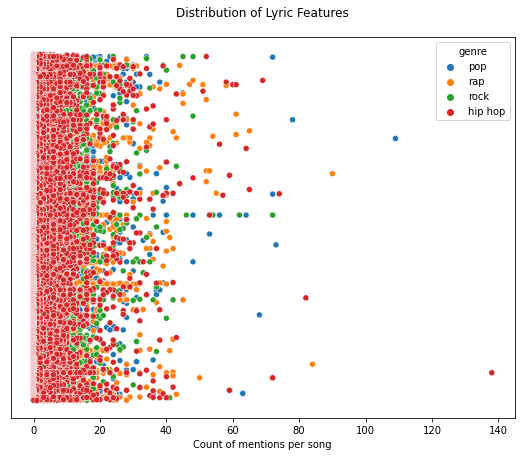

In [327]:
# Distribution of counts by lyric, coloured by genre
lboxdat = pd.DataFrame(lyrics.groupby(['song_id', 'genre']).max().select_dtypes('number').stack().reset_index()).reset_index()
fig = plt.figure(figsize = (10,7))
sns.scatterplot(data=lboxdat, x=0, y="level_2", hue = "genre")
plt.title("Distribution of Lyric Features\n")
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlabel('Count of mentions per song')
plt.gcf().subplots_adjust(left=0.2)
#fig.savefig('../writeup/Figures/DistOfLyricFeatures.jpg');

In [326]:
pd.DataFrame(lyrics.groupby(['song_id', 'genre']).max().select_dtypes('number').stack().reset_index()).reset_index()

,index,song_id,genre,level_2,0
0,0,1,pop,lyrics_across,0
1,1,1,pop,lyrics_act,0
2,2,1,pop,lyrics_actin,0
3,3,1,pop,lyrics_acting,0
4,4,1,pop,lyrics_action,0
...,...,...,...,...,...
12209995,12209995,10000,hip hop,lyrics_yet,0
12209996,12209996,10000,hip hop,lyrics_yo,1
12209997,12209997,10000,hip hop,lyrics_york,0
12209998,12209998,10000,hip hop,lyrics_young,0
